<a href="https://colab.research.google.com/github/jbeans0312/MNIST/blob/main/Bean_MNIST_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment and Data Configuration**

### Import libraries and configure device

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import confusion_matrix

# if we can run the code on the gpu, do it! otherwise, we run on the cpu (booo)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Set our hyper-params


In [8]:
input_size = 784 # number of input nodes (each image is 28x28 px)
hidden_size = 500 # size of the hidden layer (between i/o)
hidden_num = 2 # number of hidden layers (between i/o)
num_classes = 10 # number of output labels (we will be taking max prob)
num_epochs = 2  # number of epochs, during each epoch we train on all images
batch_size = 100 # number of images we train on at a given time
learning_rate = 0.001 # used in gradient descent 

### Import the MNIST data

In [9]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 81617663.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71508674.04it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21121224.16it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14918190.11it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Load the MNIST data

In [10]:
# we utilize the batch size we defined and we opt to shuffle the data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

### Visualizing Dataset


The data is a series of 60,000 28x28 px images, these are some examples
- label (top)
- image (bottom)

5


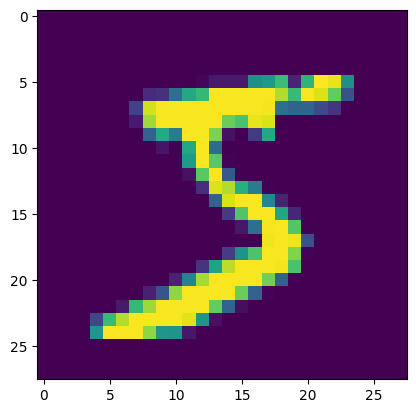

0


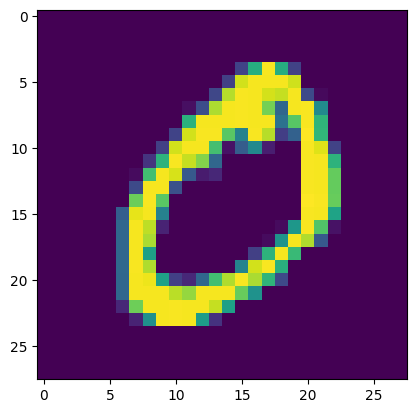

4


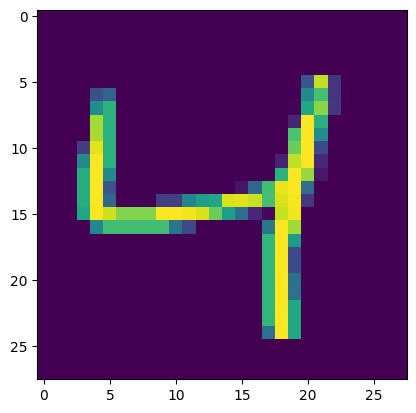

1


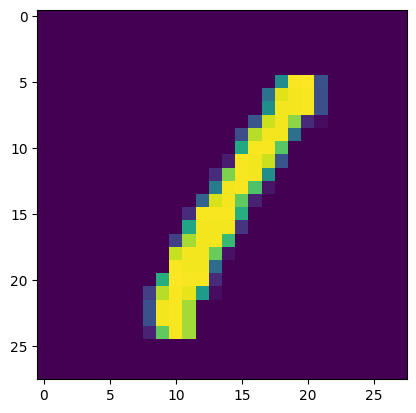

9


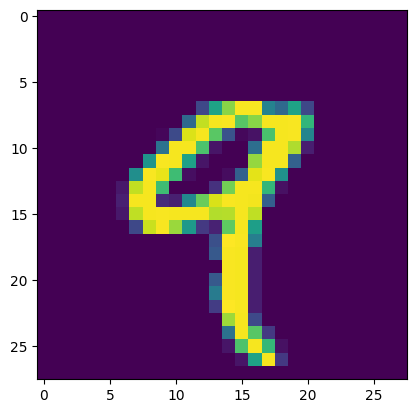

In [11]:
for i in range(5):
  example_i = train_loader.dataset[i][0].reshape(28,28)
  plt.imshow(example_i)
  print(train_loader.dataset[i][1])
  plt.show()

# **Metrics**




### Accuracy evaluation

In [12]:
def acc_eval(preds, labels):
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Displaying the confusion matrix

In [24]:
"""
The confusion matrix displays the spectrum of predictions across each class,
which predictions were truly/falsly positive (this is a 7), and which ones
were truly/falsly negative (this is a number other than 7)
"""

def plot_cm(preds, labels):
  plt.figure(figsize=(10,6))
  cm = confusion_matrix(labels, preds)
  fx = sns.heatmap(cm, annot=True,
                   fmt=".2f", cmap="GnBu")
  fx.set_title('Confusion Matrix\n')
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n')
  l = ['0','1','2','3','4','5','6','7','8','9']
  fx.xaxis.set_ticklabels(l)
  fx.yaxis.set_ticklabels(l)
  plt.show()


### Finding TP, FP, TN, and FN

In [36]:
# True positive: Predicted to be a number n, is actually that number n
# False positive: Predicted to be a number n, is actually NOT that number n
# True negative: Predicted to NOT be a number n, is actually NOT that number n
# False negative: Predicted to NOT be a number n, is actually that number n
def get_confusion_vals(preds, labels):
  cm = confusion_matrix(labels, preds)

  true_pos = np.diag(cm) # sums the diagonal of the cm
  false_pos = cm.sum(axis=0) - true_pos # cm.sum(axis=0) sums the cm rows
  false_neg = cm.sum(axis=1) - true_pos # cm.sum(axis=1) sums the cm cols

  true_neg = cm.sum() - (false_pos + false_neg + true_pos)

  return true_pos, false_pos, true_neg, false_neg

### Calculating recall, specificity, precision, and F1 score

In [15]:
"""
Each metric is in its own function in case it needs to be called later without
the use of the get_metrics function. It also helped me to seperate the formulas
visually. However you could totally do this without the extra functions.
"""

# Recall, or "true positive rate"
def get_recall(true_pos, false_neg):
  return true_pos / (true_pos + false_neg)

# Specificity, or "true negative rate"
def get_specificity(true_neg, false_pos):
  return true_neg / (true_neg + false_pos)

# Precision, or "positive predictive rate"
def get_precision(true_pos, false_pos):
  return true_pos / (true_pos + false_pos)

# F1 Score, measures a model's accuracy by combining precision and recall scores
def get_f1(precision, recall):
  return (2 * precision * recall) / (precision + recall)

# Calls other metric evaluation functions
def get_metrics(true_pos, false_pos, true_neg, false_neg):
  r = get_recall(true_pos, false_neg)
  s = get_specificity(true_neg, false_pos)
  p = get_precision(true_pos, false_pos)
  f1 = get_f1(p,r)

  return r, s, p, f1

### Printing metrics

In [45]:
def show_metrics(preds, labels):
  acc = acc_eval(preds, labels)
  plot_cm(preds, labels)
  tp, fp, tn, fn = get_confusion_vals(preds, labels)
  recall, specif, precis, f1 = get_metrics(tp, fp, tn, fn)
  print('\n=====Conf. Matrix======')
  print(f'True positives: {tp}')
  print(f'False positives: {fp}')
  print(f'True negatives: {tn}')
  print(f'False negatives: {fn}')
  print('\n=====Eval. Metrics=====')
  print(f'Accuracy: {acc.item()*100:.4f}%') 
  print('-------------')
  print(f'Class Specific Recall:\n\n{recall}')
  print(f'\nAverage Recall: {np.mean(recall)}')
  print('-------------')
  print(f'Class Specific Specificity:\n\n{specif}')
  print(f'\nAverage Specificity: {np.mean(specif)}')
  print('-------------')
  print(f'Class Specific Precision:\n\n{precis}')
  print(f'\nAverage Precison: {np.mean(precis)}')
  print('-------------')
  print(f'Class Specific F1 Score:\n\n{f1}')
  print(f'\nAverage F1 Score: {np.mean(f1)}')

# **Feed Forward NN**

### Create NeuralNet class utilizing Torch NN module

In [19]:
# fully connected neural network with one hidden layer

# implement functionality for finetuning hidden_size and hidden_layer_num
# hidden_size = number of nodes per layer
# hidden_num = number of layers in the ****hidden zone*****

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, hidden_num):
        """Python note: we use super().__init__() to inherit all 
        values initialized in the parent (super) class. In this case
        there are probably a bunch of variables predefined in the Torch
        NN class that we need to access, but don't want to mess with."""
        super(NeuralNet, self).__init__() 
        """We set the rest of the attributes to OUR hyper-params that we 
        defined in [3]"""
        # here we init ReLU
        self.relu = nn.ReLU() # ReLU acivation function from torch
        self.input_size = input_size # here we specify the input size
        self.hidden_num = hidden_num # here we specify the num of hidden layers
       
        # Create our layers
        
        self.input_layer = nn.Linear(input_size, hidden_size) # first layer
        
        self.hidden_layers = nn.ModuleList() # list for remaining hidden layers
        
        for i in range(0, hidden_num): # create remaining layers
          self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.output_layer = nn.Linear(hidden_size, num_classes) # output layer
    
    """Here we define our feed forward method, we won't be using softmax at
    the moment, but we will be utilizing it later. 
    
    Torch note: Every nn.Module subclass implements the operations in the 
    forward method on the data."""
    def forward(self, x):
        # Utilize hidden layers and apply activation (ReLU)
        out = self.relu(self.input_layer(x)) # input layer

        for i in range(self.hidden_num): # hidden layers
          out = self.relu(self.hidden_layers[i](out))

        out = self.output_layer(out) # output layer
        return out

model = NeuralNet(input_size, hidden_size, num_classes, hidden_num).to(device)

### Function to calculate total parameters

In [20]:
def count_parameters(model):
  # p.numel() sums all the combinations of parameters
  # p.numel([500,500]) yields 500^2 params 
    return sum(p.numel() for p in model.parameters())

### Initialize loss function (criterion) and optimizer

In [21]:
"""
Here we select Cross Entropy Loss (CEL) as our loss function. We choose CEl as 
it is well suited for multi-class classification problems, and produces models
that make predictions with high confidence. 

Note: we could also try implementing Negative Log Likelihood Loss (NLL), as it 
is also well suited for mcc problems.
"""
criterion = nn.CrossEntropyLoss() # softmax is built in
"""
Adam is a pytorch method for implementing a stochastic optimization algorithm.
Adam falls under the umbrella of gradient descent algorithms, and is effecient
for working with large batches of data (like MNIST)--or I guess MNIST isn't that
large in the scheme of large things :o
"""
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Create training loop


In [22]:
n_total_steps = len(train_loader) # get the total number of training instances

"""
Here we utilize a nested for loop since we need to iterate over epochs, and 
train in batches inside of those epochs.
"""
for epoch in range(num_epochs): 
  for i, (images, labels) in enumerate(train_loader):
    """
    We need to reshape the training data since it comes packed in a tuple 
    containing a matrix of pixel values and a target value, we want it to be a 
    1D so we can feed the data into our net
    """
    images = images.reshape(-1, 28*28).to(device) # reshape the data
    labels = labels.to(device) # upload the labels to the device 
    """
    Here we pass our image data arr[input_size] through the model and calculate
    the loss function.
    """
    outputs = model(images) # run the input data through our model
    loss = criterion(outputs, labels) # run the loss function (CLE)
    """
    Now that we have the output from our loss function, we preform stochastic
    (one at a time) gradient descent optimization using Adam. This updates our
    weights after every training instance.
    """
    optimizer.zero_grad() # initializes the gradient tensor to zero 
    loss.backward() # back-prop and compute the gradient
    optimizer.step() # preform a single optimization step 
    """
    To track our runtime progress we will print the loss function after every 
    100th step and show our total steps.
    """
    if (i+1) % 100 == 0:
      print(f'Epoch[{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch[1/2], Step[100/600], Loss: 0.2126
Epoch[1/2], Step[200/600], Loss: 0.2616
Epoch[1/2], Step[300/600], Loss: 0.1125
Epoch[1/2], Step[400/600], Loss: 0.0895
Epoch[1/2], Step[500/600], Loss: 0.1584
Epoch[1/2], Step[600/600], Loss: 0.1073
Epoch[2/2], Step[100/600], Loss: 0.1088
Epoch[2/2], Step[200/600], Loss: 0.1943
Epoch[2/2], Step[300/600], Loss: 0.1149
Epoch[2/2], Step[400/600], Loss: 0.0311
Epoch[2/2], Step[500/600], Loss: 0.1102
Epoch[2/2], Step[600/600], Loss: 0.1254


### Evaluate metrics

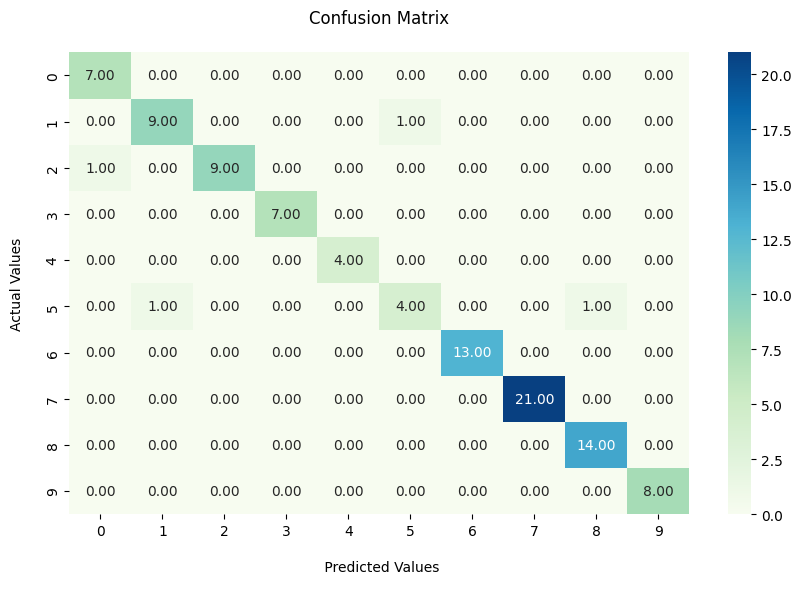

=====Conf. Matrix======
True positives: [ 7  9  9  7  4  4 13 21 14  8]
False positives: [1 1 0 0 0 1 0 0 1 0]
True negatives: [92 89 90 93 96 93 87 79 85 92]
False negatives: [0 1 1 0 0 2 0 0 0 0]

=====Eval. Metrics=====
Accuracy: 96.0000%
-------------
Class Specific Recall:

[1.         0.9        0.9        1.         1.         0.66666667
 1.         1.         1.         1.        ]

Average Recall: 0.9466666666666667
-------------
Class Specific Specificity:

[0.98924731 0.98888889 1.         1.         1.         0.9893617
 1.         1.         0.98837209 1.        ]

Average Specificity: 0.9955869995867761
-------------
Class Specific Precision:

[0.875      0.9        1.         1.         1.         0.8
 1.         1.         0.93333333 1.        ]

Average Precison: 0.9508333333333333
-------------
Class Specific F1 Score:

[0.93333333 0.9        0.94736842 1.         1.         0.72727273
 1.         1.         0.96551724 1.        ]

Average F1 Score: 0.9473491723038002

In [44]:
# Print the metrics for our Feed Forward model
with torch.no_grad(): # ensure that we do not update the weights on accident
  preds = torch.max(outputs, dim=1)[1] # gets the predictions generated by NN
  show_metrics(preds, labels) # calls the show_metrics in the Metrics block
